In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import transformers
from transformers import pipeline

In [2]:
df = pd.read_csv("Opal/Data/preprocessed_osteoporosis_prob.csv")

In [3]:
bin_age = []


for age in df['Age']:
    if age == '7-12':
        bin_age.append('0-44')
    elif age == '13-18':
        bin_age.append('0-44')
    elif age == '19-24':
        bin_age.append('0-44')
    elif age == '25-34':
        bin_age.append('0-44')
    elif age == '35-44':
        bin_age.append('0-44')
    elif age == '45-54':
        bin_age.append('45-54')
    elif age == '55-64':
        bin_age.append('55-64')
    elif age == '65-74':
        bin_age.append('65-74')
    elif age == '75 or over':
        bin_age.append('75+')
    else:
        #missing values
        bin_age.append('')

df['Age'] = bin_age

In [4]:
Review = []

for satisfaction in df['Satisfaction']:
    if satisfaction < 3:
        Review.append('bad')
    else:
        Review.append('good')

df['Review'] = Review

## n-gram helper functions

In [5]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#Enhanced stopwording
more_stopwords = {'went', 'go', 'one', 'two', '2', '3', 'side', 'effects'}
stopwords = stopwords.union(more_stopwords)

In [6]:
from collections import defaultdict
import nltk
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
"""import nltk
from collections import defaultdict
from nltk.tokenize import word_tokenize
#nltk.word_tokenize(df_ost['Reviews'].iloc[0])

tokenizer = nltk.RegexpTokenizer(r"\w+")
#new_words = tokenizer.tokenize(df_ost['Reviews'].iloc[0])"""

'import nltk\nfrom collections import defaultdict\nfrom nltk.tokenize import word_tokenize\n#nltk.word_tokenize(df_ost[\'Reviews\'].iloc[0])\n\ntokenizer = nltk.RegexpTokenizer(r"\\w+")\n#new_words = tokenizer.tokenize(df_ost[\'Reviews\'].iloc[0])'

In [7]:
def remove_punc(string):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    for ele in string:  
        if ele in punc:  
            string = string.replace(ele, "") 
    return string

In [8]:
def generate_ngrams(text, n_gram=1):
    from nltk.tokenize import word_tokenize
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    #text = tokenizer.tokenize(text)

    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
    token = [remove_punc(i) for i in token]
    #token = [token for token in tokenizer.tokenize(text) if token != "" if token not in STOPWORDS]
    
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [9]:
## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Effectiveness

In [10]:
#have as probabilities instead of 0 or 1
df_effectiveness = df[df["effectiveness"]>0.7]

In [11]:
freq_dict = defaultdict(int)
for sent in df_effectiveness[df_effectiveness["Review"] == 'bad']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(10), 'orange')

freq_dict = defaultdict(int)
for sent in df_effectiveness[df_effectiveness["Review"] == 'good']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(10), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of Bad Reviews", 
                                          "Frequent biagrams of Good Reviews"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Side Effects - Bigrams

In [12]:
df_side_effects = df[df["side_effect"]>0.7].reset_index()

In [13]:
df_side_effects['Reviews']

0       After taking this drug for approx. 21 days I s...
1       I have taken this drug for almost 7 years with...
2       I have severe pain in my hand and muscle joint...
3       Food dyes and talc...large pill for a newly re...
4       I have taken it for 6 months and it did not in...
                              ...                        
1307    The only thing I have to say against these tab...
1308    Just started taking this a month ago. Definite...
1309    This supplement has caused much gas, bloating,...
1310    first dose: one tablet knocked me out cold for...
1311    My father is using Calcidol Drops (10 drops/da...
Name: Reviews, Length: 1312, dtype: object

In [14]:
freq_dict = defaultdict(int)
for sent in df_side_effects[df_side_effects["Review"] == 'bad']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

freq_dict = defaultdict(int)
for sent in df_side_effects[df_side_effects["Review"] == 'good']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of Bad Reviews", 
                                          "Frequent biagrams of Good Reviews"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Classification

In [15]:
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

### Sample Experimentation

In [16]:
"""#A sample review that contains a) whether the medicine worked b) the type of side effect and c) the delivery method (pill)

sample_review = "This osteoporosis medicine worked, but it gave me a nasty stomach ache. It was easy to swallow."


res = classifier(
    sample_review,
    candidate_labels = ['limb pain', 'gastrointestinal', 'dental', 'cardiac', 'dermatological', 'respiratory' , 'weight gain and loss', 'headache'], 
    multi_class = True
)
res"""

'#A sample review that contains a) whether the medicine worked b) the type of side effect and c) the delivery method (pill)\n\nsample_review = "This osteoporosis medicine worked, but it gave me a nasty stomach ache. It was easy to swallow."\n\n\nres = classifier(\n    sample_review,\n    candidate_labels = [\'limb pain\', \'gastrointestinal\', \'dental\', \'cardiac\', \'dermatological\', \'respiratory\' , \'weight gain and loss\', \'headache\'], \n    multi_class = True\n)\nres'

In [17]:
sides = ['limb pain', 'gastrointestinal', 'dental', 'cardiac', 'dermatological', 'respiratory' , 'weight gain and loss', 'headache', 'menstrual', 'fatigue', 'body temperature']

In [18]:
#setting empty values for the columns
index = -1
for label in sides:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['Reviews'],
        candidate_labels = sides,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

c:\Users\Woon.Kim\Anaconda33\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
#df.to_csv('data/updated_df.csv')

In [35]:
df['max'] = df[['limb pain_m', 'gastrointestinal_m', 'dental_m', 'cardiac_m', 'dermatological_m', 'respiratory_m', 'weight gain and loss_m', 'headache_m', 'menstrual_m', 'fatigue_m', 'body temperature_m']].max(axis=1)
df.head()

,Unnamed: 0,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,...,dental_m,cardiac_m,dermatological_m,respiratory_m,weight gain and loss_m,headache_m,menstrual_m,fatigue_m,body temperature_m,max
0,0,0-44,Osteoporosis,2010-03-16,lotensin,6883,4,3,this treatment is awsome. I love drugs.,2,...,0.012045,0.090442,0.185604,0.196592,0.087278,0.151928,0.005952,0.049910,0.005420,0.196592
1,1,45-54,Post-Menopausal Osteoporosis Prevention,2017-07-31,lopreeza,167327,5,2,After taking this drug for approx. 21 days I s...,3,...,0.009981,0.067002,0.222304,0.143084,0.031699,0.041735,0.881157,0.159944,0.031104,0.881157
2,2,45-54,Post-Menopausal Osteoporosis Prevention,2016-12-29,lopreeza,167327,5,5,I have taken this drug for almost 7 years with...,5,...,0.058516,0.061539,0.294107,0.320504,0.059767,0.015010,0.463517,0.031509,0.257710,0.463517
3,3,65-74,Osteoporosis,2010-05-26,liquid calcium + vitamin d,93396,5,5,since I have a hard time swallowing this hs wo...,5,...,0.369095,0.021584,0.012158,0.062320,0.263505,0.105072,0.028178,0.353670,0.003373,0.983138
4,4,45-54,Osteoporosis,2012-01-19,oyster shell + d,94390,1,1,I have severe pain in my hand and muscle joint...,1,...,0.000074,0.000637,0.001936,0.002675,0.002148,0.038169,0.000281,0.032021,0.001090,0.999138


# Side Effects

In [36]:
df_side_effects = df[df["side_effect"]>0.7].reset_index()

In [37]:
print(len(df))
print(len(df_side_effects))
print(round(len(df_side_effects)/len(df),2))

1357
1312
0.97


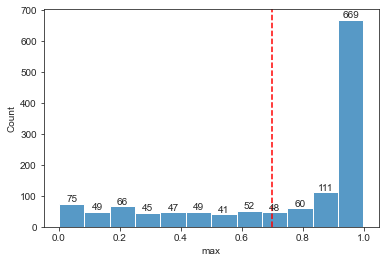

In [43]:
sns.set_style('ticks')
fig, ax = plt.subplots()
ax = sns.histplot(x = 'max', data = df_side_effects)
plt.axvline(0.7, 0,700, c = 'r', ls = '--')
for container in ax.containers:
    ax.bar_label(container)

In [44]:
print(len(df_side_effects[df_side_effects['max'] > 0.7]))
print(len(df_side_effects))
print(round(len(df_side_effects[df_side_effects['max'] > 0.7])/len(df_side_effects),2))

866
1312
0.66


## Bigrams of < 0.7 confidence

In [45]:
df_side_effects.to_csv('temp.csv', index = False)

In [46]:
df2 = df_side_effects[df_side_effects['max'] < 0.7]

In [48]:
freq_dict = defaultdict(int)
for sent in df2[df2["Review"] == 'bad']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

freq_dict = defaultdict(int)
for sent in df2[df2["Review"] == 'good']['Reviews']:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(30), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of Bad Reviews", 
                                          "Frequent biagrams of Good Reviews"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

In [50]:
side1 = []
side2 = []
side3 = []
side4 = []
side5 = []
side6 = []
side7 = []
side8 = []
side9 = []
side10 = []
side11 = []
side12 = []

thresh = 0.7

for i in range(len(df_side_effects)):
    if df_side_effects['limb pain_m'][i] >= thresh:
        side1.append(1)
    elif df_side_effects['limb pain_m'][i] < thresh:
        side1.append(0)
    
    if df_side_effects['gastrointestinal_m'][i] >= thresh:
        side2.append(1)
    elif df_side_effects['gastrointestinal_m'][i] < thresh:
        side2.append(0)

    if df_side_effects['dental_m'][i] >= thresh:
        side3.append(1)
    elif df_side_effects['dental_m'][i] < thresh:
        side3.append(0)

    if df_side_effects['cardiac_m'][i] >= thresh:
        side4.append(1)
    elif df_side_effects['cardiac_m'][i] < thresh:
        side4.append(0)

    if df_side_effects['dermatological_m'][i] >= thresh:
        side5.append(1)
    elif df_side_effects['dermatological_m'][i] < thresh:
        side5.append(0)

    if df_side_effects['respiratory_m'][i] >= thresh:
        side6.append(1)
    elif df_side_effects['respiratory_m'][i] < thresh:
        side6.append(0)

    if df_side_effects['weight gain and loss_m'][i] >= thresh:
        side7.append(1)
    elif df_side_effects['weight gain and loss_m'][i] < thresh:
        side7.append(0)

    if df_side_effects['headache_m'][i] >= thresh:
        side8.append(1)
    elif df_side_effects['headache_m'][i] < thresh:
        side8.append(0)

    if df_side_effects['menstrual_m'][i] >= thresh:
        side9.append(1)
    elif df_side_effects['menstrual_m'][i] < thresh:
        side9.append(0)

    if df_side_effects['fatigue_m'][i] >= thresh:
        side10.append(1)
    elif df_side_effects['fatigue_m'][i] < thresh:
        side10.append(0)

    if df_side_effects['body temperature_m'][i] >= thresh:
        side11.append(1)
    elif df_side_effects['body temperature_m'][i] < thresh:
        side11.append(0)    

    if df_side_effects['max'][i] < thresh:
        side12.append(1)
    elif df_side_effects['max'][i] >= thresh:
        side12.append(0)



df_side_effects['limb pain'] = side1
df_side_effects['gastrointestinal'] = side2
df_side_effects['dental'] = side3
df_side_effects['cardiac'] = side4
df_side_effects['dermatological'] = side5
df_side_effects['respiratory'] = side6
df_side_effects['weight'] = side7
df_side_effects['headache'] = side8
df_side_effects['menstrual'] = side9
df_side_effects['fatigue'] = side10
df_side_effects['body temperature'] = side11
df_side_effects['other'] = side12

In [51]:
side_tf = []

for i in range(len(df_side_effects)):
    if df_side_effects['limb pain'][i] == 1:
        side_tf.append('limb')
    elif df_side_effects['gastrointestinal'][i] == 1:
        side_tf.append('gastro')
    elif df_side_effects['dental'][i] == 1:
        side_tf.append('dental')
    elif df_side_effects['cardiac'][i] == 1:
        side_tf.append('cardiac')
    elif df_side_effects['dermatological'][i] == 1:
        side_tf.append('derma')
    elif df_side_effects['respiratory'][i] == 1:
        side_tf.append('respiratory')
    elif df_side_effects['weight'][i] == 1:
        side_tf.append('weight')
    elif df_side_effects['headache'][i] == 1:
        side_tf.append('headache')
    elif df_side_effects['menstrual'][i] == 1:
        side_tf.append('menstrual')
    elif df_side_effects['fatigue'][i] == 1:
        side_tf.append('fatigue')
    elif df_side_effects['body temperature'][i] == 1:
        side_tf.append('body temperature')    
    elif df_side_effects['other'][i] == 1:
        side_tf.append('other')

df_side_effects['side_tf'] = side_tf

# Reclast

In [299]:
df_reclast = df_side_effects.loc[df_side_effects['Drug'].str.contains("reclast", case=False)]
df_reclast[['Age', 'limb pain_m', 'gastrointestinal_m', 'dental_m', 'cardiac_m', 'dermatological_m', 'respiratory_m', 'weight gain and loss_m', 'headache_m', 'menstrual_m', 'fatigue_m', 'body temperature_m']].head(20)

,Age,limb pain_m,gastrointestinal_m,dental_m,cardiac_m,dermatological_m,respiratory_m,weight gain and loss_m,headache_m,menstrual_m,fatigue_m,body temperature_m
313,65-74,0.482234,0.024034,0.032754,0.037358,0.041103,0.040736,0.041339,0.957242,0.047248,0.025091,0.037581
314,55-64,0.170215,0.084295,0.003973,0.064991,0.025329,0.088252,0.016321,0.158650,0.006581,0.977999,0.168132
315,55-64,0.478662,0.474996,0.207362,0.217192,0.327329,0.201123,0.117474,0.956907,0.091535,0.942449,0.363197
316,65-74,0.972416,0.023580,0.030495,0.153125,0.045583,0.047774,0.111619,0.109082,0.011689,0.226768,0.585539
317,55-64,0.489293,0.024543,0.076346,0.052079,0.007409,0.024282,0.069954,0.257151,0.027912,0.985784,0.320765
318,65-74,0.995420,0.027077,0.018653,0.032995,0.026876,0.649168,0.006193,0.953200,0.005508,0.985766,0.694106
319,65-74,0.284044,0.610164,0.014891,0.017292,0.017823,0.075067,0.054317,0.972538,0.014536,0.330966,0.147760
320,55-64,0.998838,0.058549,0.006212,0.017878,0.028276,0.110651,0.233699,0.021118,0.016030,0.169018,0.109146
321,55-64,0.008638,0.018428,0.001784,0.376629,0.017702,0.979339,0.004660,0.992892,0.002319,0.133856,0.202241
322,55-64,0.996738,0.137837,0.086208,0.107443,0.111713,0.260238,0.043117,0.988839,0.031796,0.931291,0.197809


In [300]:
print(df_reclast['Reviews'][313])
print('')
print(df_reclast['Reviews'][329])

I have had two infusions of Reclast with no side effects other than a mild headache the day after. I haven't had a Bone Density yet but have noticed that my fingernails are much harder. I am hopeful and will definitely continue with the yearly injection. 


My wife had Reclast twice with no problems. Following her advice, I had the iv over 40 minutes instead of 20 minutes. I had no problem until the night of the iv. During the night, the bones in my chest ached, I had lower back and hip pains, and I was very tired and weak. The bone pain stopped in the morning but the back and hip pain continued. I slept almost all of the next 28 hours. In the middle of the 28 hours, I had nausea and dry heaves. A dose of ondansetron cured the nausea. I made the mistake of not being adequately hydrated before and after the iv. I regained most of my strength two days after the iv.


# TYMLOS

In [52]:
pd.set_option('display.max_colwidth', None)

In [53]:
df_tymlos = df_side_effects.loc[df_side_effects['Drug'].str.contains("tymlos", case=False)]

In [54]:
df_tymlos[['Age', 'limb pain_m', 'gastrointestinal_m', 'dental_m', 'cardiac_m', 'dermatological_m', 'respiratory_m', 'weight gain and loss_m', 'headache_m', 'menstrual_m', 'fatigue_m', 'body temperature_m']]

,Age,limb pain_m,gastrointestinal_m,dental_m,cardiac_m,dermatological_m,respiratory_m,weight gain and loss_m,headache_m,menstrual_m,fatigue_m,body temperature_m
800,55-64,0.000064,0.010645,0.009317,0.144770,0.016742,0.955604,0.024242,0.004002,0.018973,0.016796,0.036469
801,55-64,0.683069,0.000926,0.239098,0.207960,0.002154,0.003112,0.002964,0.016773,0.007174,0.005227,0.001398
802,65-74,0.974608,0.052169,0.001068,0.007542,0.018171,0.002235,0.116981,0.078270,0.155620,0.904609,0.042844


In [55]:
df_tymlos[['Age', 'limb pain', 'gastrointestinal', 'dental', 'cardiac', 'dermatological', 'respiratory', 'weight', 'headache', 'menstrual', 'fatigue', 'body temperature']]

,Age,limb pain,gastrointestinal,dental,cardiac,dermatological,respiratory,weight,headache,menstrual,fatigue,body temperature
800,55-64,0,0,0,0,0,1,0,0,0,0,0
801,55-64,0,0,0,0,0,0,0,0,0,0,0
802,65-74,1,0,0,0,0,0,0,0,0,1,0


In [56]:
print(df_tymlos['Reviews'][800])
print('')
print(df_tymlos['Reviews'][801])
print('')
print(df_tymlos['Reviews'][802])

It’s easy to do but no where on the side effects do I see why I get such a bad chest tightening.  However, all side effects only last about an hour so I give myself a shot an hour before bed.  Only been doing it for a month so we’ll see.

I do have about a two hour increase in heart rate but find if I hydrate a lot before using, it helps that. Had 2 fractures and was still having microfractures prior to taking.  From that I was in a lot of pain but within a month of taking Tymlos, I felt stronger with much less pain, more like my old self again.

i frill diary often during the day and it makes me sad sometime and I am achey in my joints all the time and i bruise very easily especially my abdomen.


## EDA (age distribution, ie dental things tend to affect older people)

In [ ]:
df_side_effects.drop(['Unnamed: 0'], axis = 1)

# Side Effects EDA

In [59]:
df_limb = df_side_effects[df_side_effects['limb pain'] == 1]
df_gastro = df_side_effects[df_side_effects['gastrointestinal'] == 1]
df_dental = df_side_effects[df_side_effects['dental'] == 1]
df_cardiac = df_side_effects[df_side_effects['cardiac'] == 1]
df_derma = df_side_effects[df_side_effects['dermatological'] == 1]
df_resp = df_side_effects[df_side_effects['respiratory'] == 1]
df_weight = df_side_effects[df_side_effects['weight'] == 1]
df_headache = df_side_effects[df_side_effects['headache'] == 1]
df_menstrual = df_side_effects[df_side_effects['menstrual'] == 1]
df_fatigue = df_side_effects[df_side_effects['fatigue'] == 1]
df_bodytemp = df_side_effects[df_side_effects['body temperature'] == 1]
df_other = df_side_effects[df_side_effects['other'] == 1]

In [60]:
total = len(df_side_effects)
print('limb side effects: ', round((len(df_limb)/total)*100,2), '%')
print('gastrointesntinal side effects: ', round((len(df_gastro)/total)*100,2), '%')
print('headache side effects: ', round((len(df_headache)/total)*100,2), '%')
print('respiratory side effects: ', round((len(df_resp)/total)*100,2), '%')
print('weight loss/gain side effects: ', round((len(df_weight)/total)*100,2), '%')
print('dental side effects: ', round((len(df_dental)/total)*100,2), '%')
print('dermatological side effects: ', round((len(df_derma)/total)*100,2), '%')
print('cardiac side effects: ', round((len(df_cardiac)/total)*100,2), '%')
print('menstrual side effects: ', round((len(df_menstrual)/total)*100,2), '%')
print('fatigue side effects: ', round((len(df_fatigue)/total)*100,2), '%')
print('body temperatue side effects: ', round((len(df_bodytemp)/total)*100,2), '%')
print('other: ', round((len(df_other)/total)*100,2), '%')

limb side effects:  34.68 %
gastrointesntinal side effects:  14.33 %
headache side effects:  11.43 %
respiratory side effects:  5.41 %
weight loss/gain side effects:  3.51 %
dental side effects:  3.35 %
dermatological side effects:  1.75 %
cardiac side effects:  1.22 %
menstrual side effects:  3.51 %
fatigue side effects:  19.05 %
body temperatue side effects:  6.78 %
other:  33.99 %


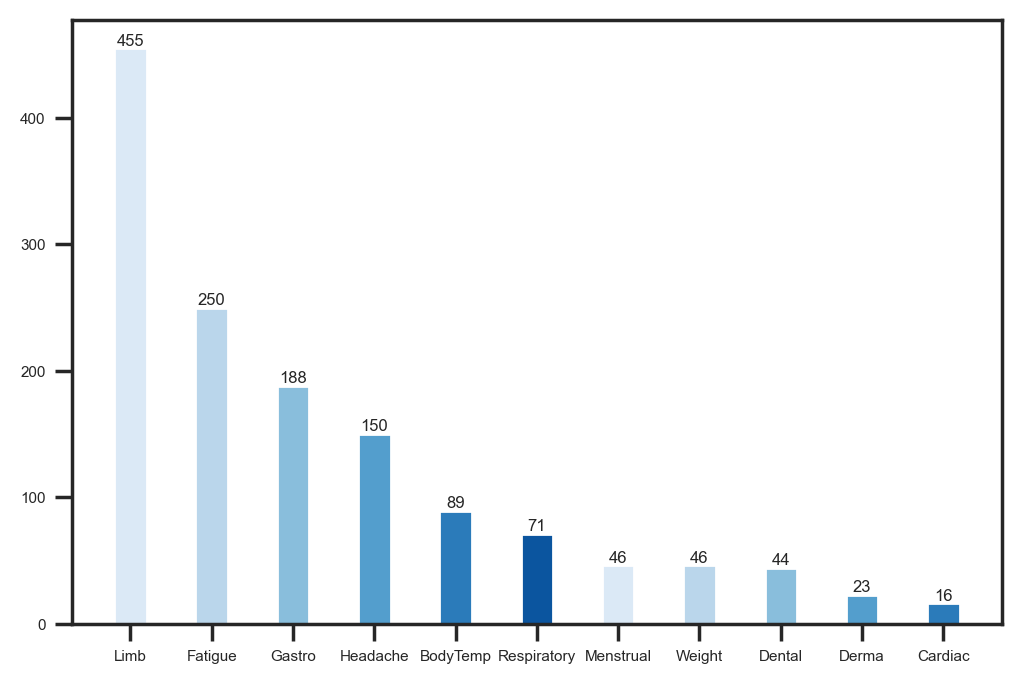

In [222]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200},
        font_scale=0.5,
        style="white"
        )

sns.set_style('ticks')
fig, ax = plt.subplots()

#define data
data = [len(df_limb), len(df_fatigue), len(df_gastro), len(df_headache), len(df_bodytemp), len(df_resp), len(df_menstrual), len(df_weight), len(df_dental), len(df_derma), len(df_cardiac)]
labels = ['Limb', 'Fatigue', 'Gastro', 'Headache', 'BodyTemp', 'Respiratory', 'Menstrual', 'Weight', 'Dental', 'Derma', 'Cardiac']

#define Seaborn color palette to use
colors = sns.color_palette('Blues')[0:11]

#create pie chart
plt.bar(labels, data, color = colors,
        width = 0.4)
#plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

Text(0.5, 1.0, 'Limb Pain')

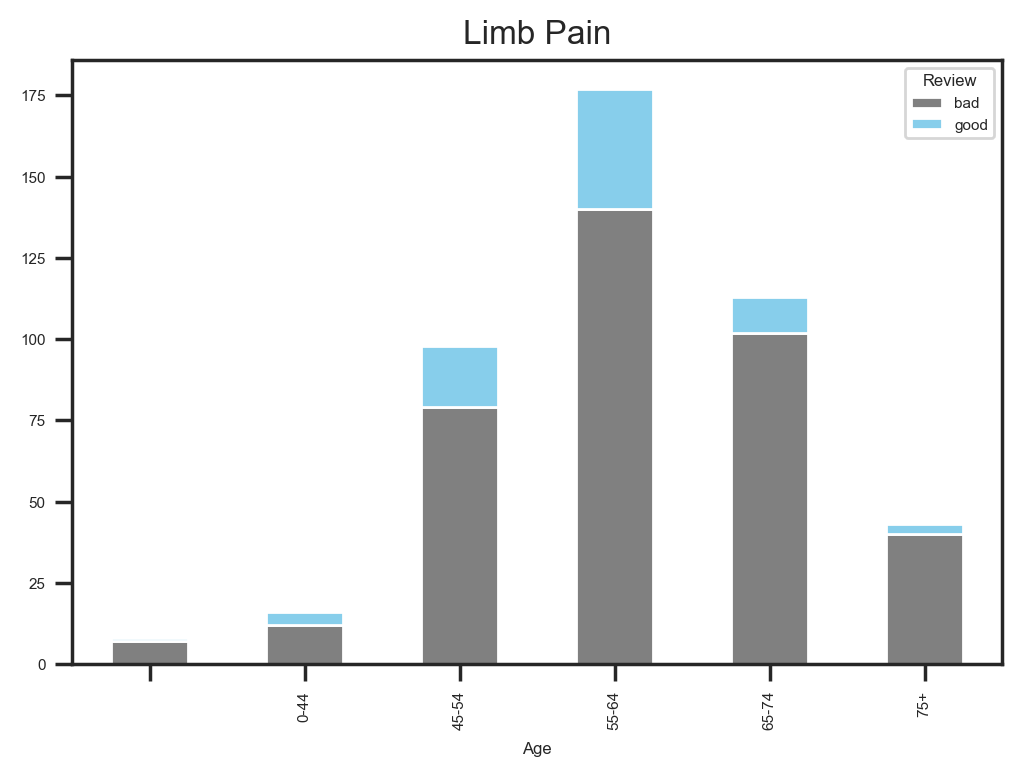

In [76]:
df_plot = df_limb.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Limb Pain', fontsize=12)

Text(0.5, 1.0, 'Gastrointesntinal')

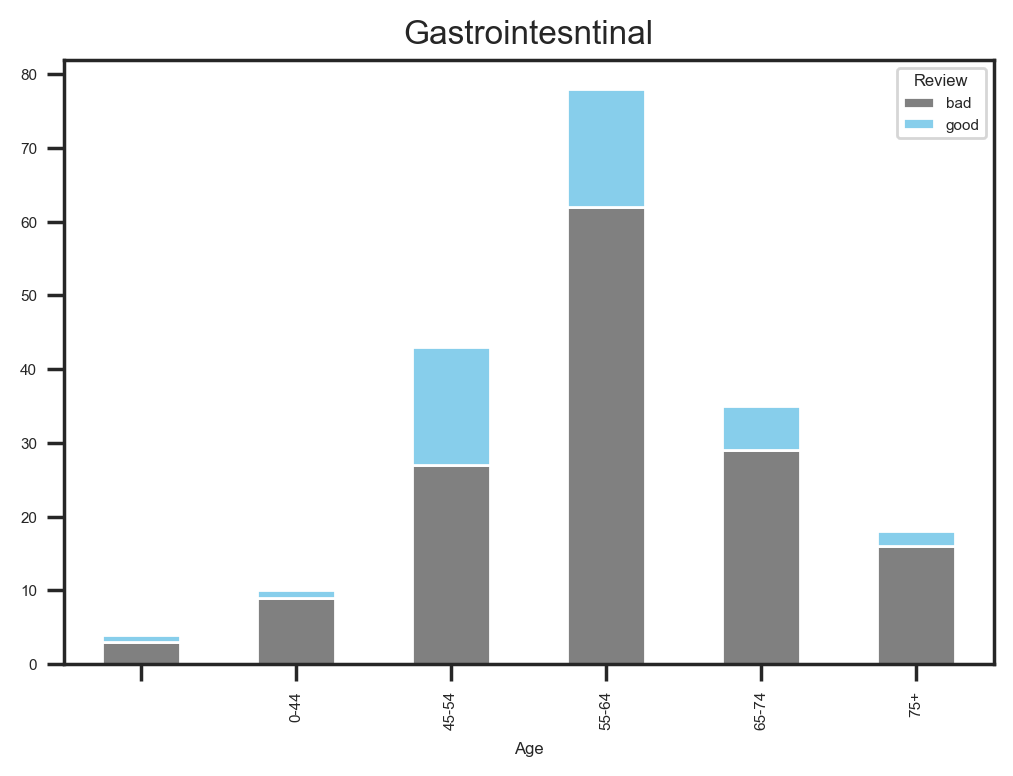

In [77]:
df_plot = df_gastro.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Gastrointesntinal', fontsize=12)

Text(0.5, 1.0, 'Dental')

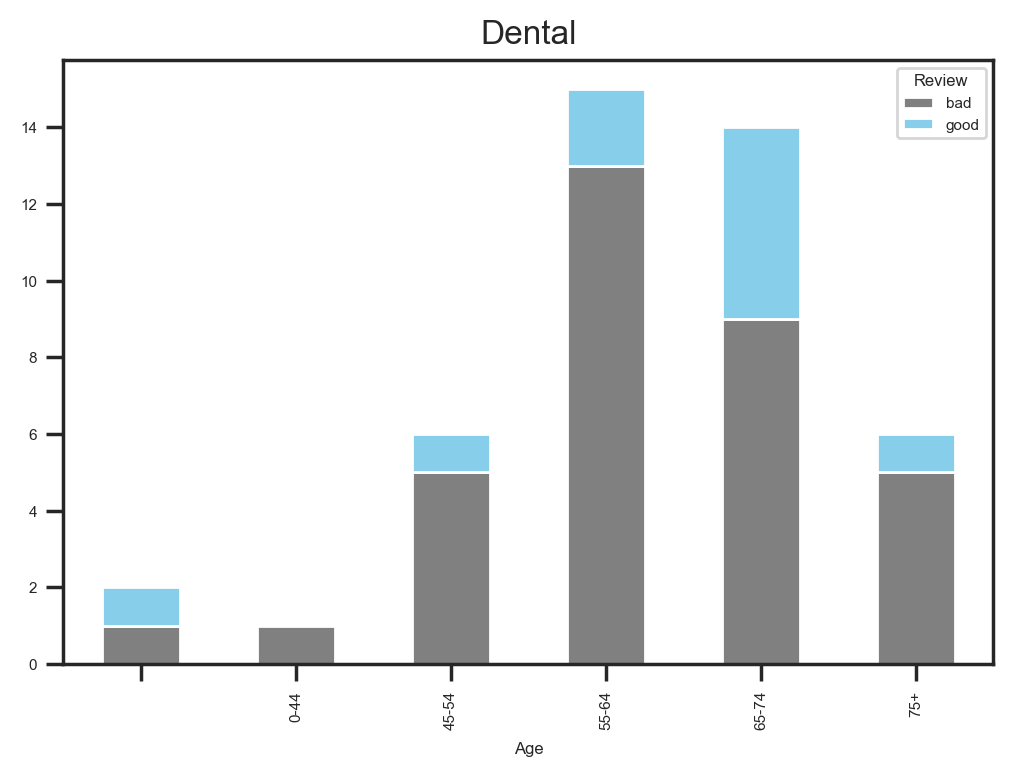

In [78]:
df_plot = df_dental.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Dental', fontsize=12)

Text(0.5, 1.0, 'Cardiac')

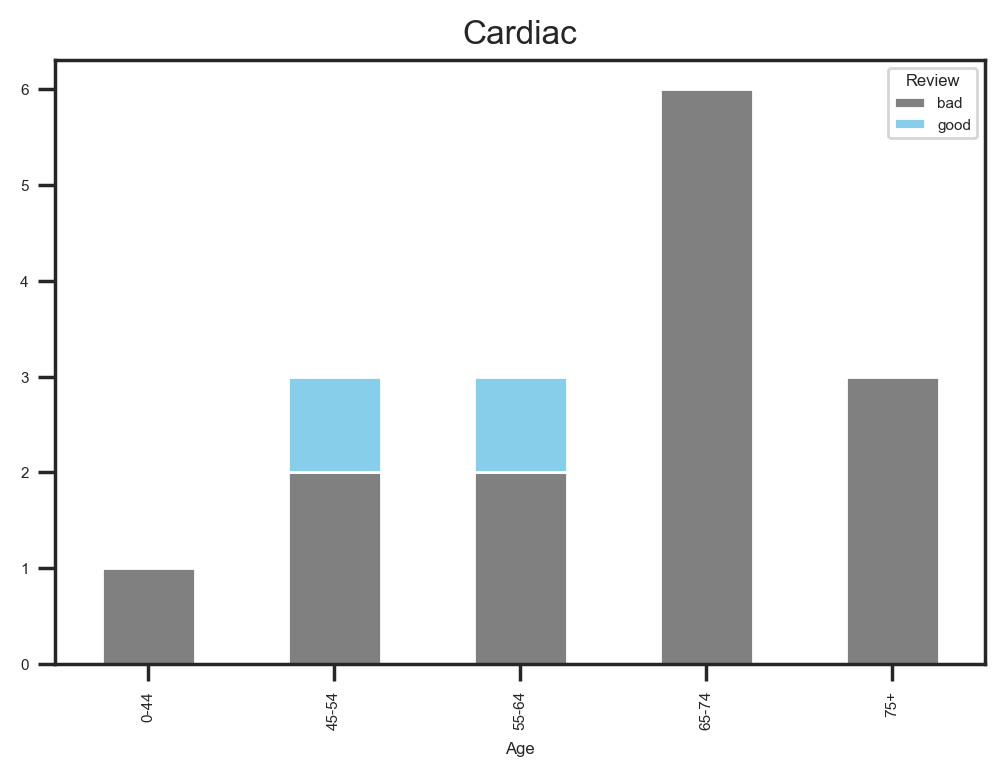

In [79]:
df_plot = df_cardiac.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Cardiac', fontsize=12)

Text(0.5, 1.0, 'Dematological')

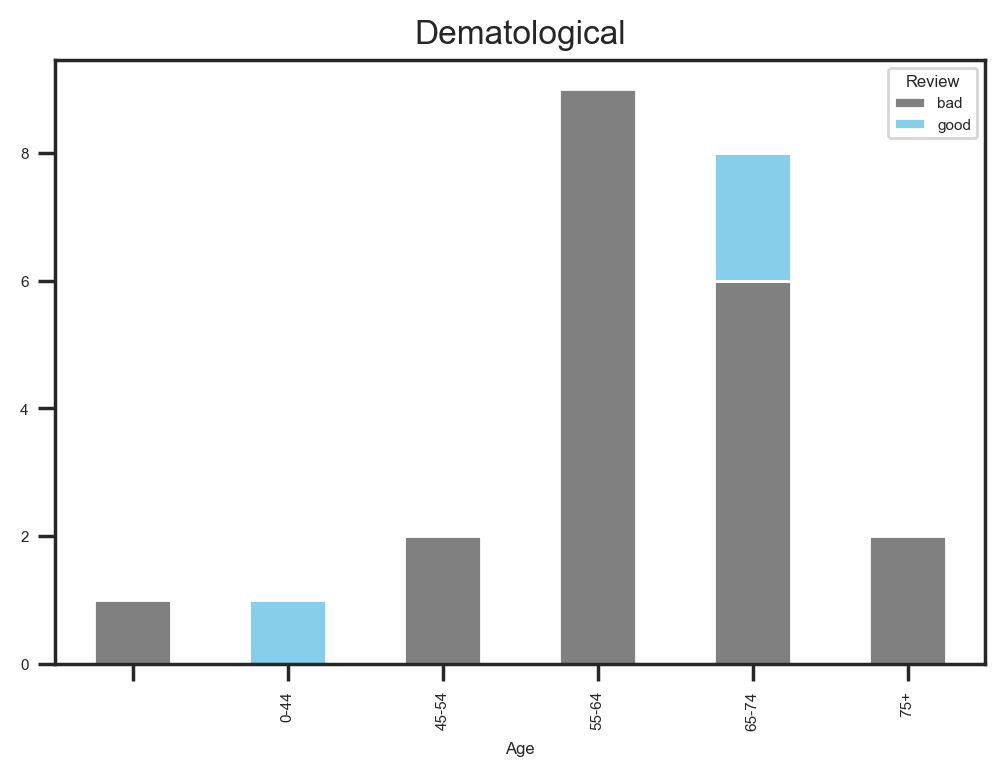

In [80]:
df_plot = df_derma.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Dematological', fontsize=12)

Text(0.5, 1.0, 'Respiratory')

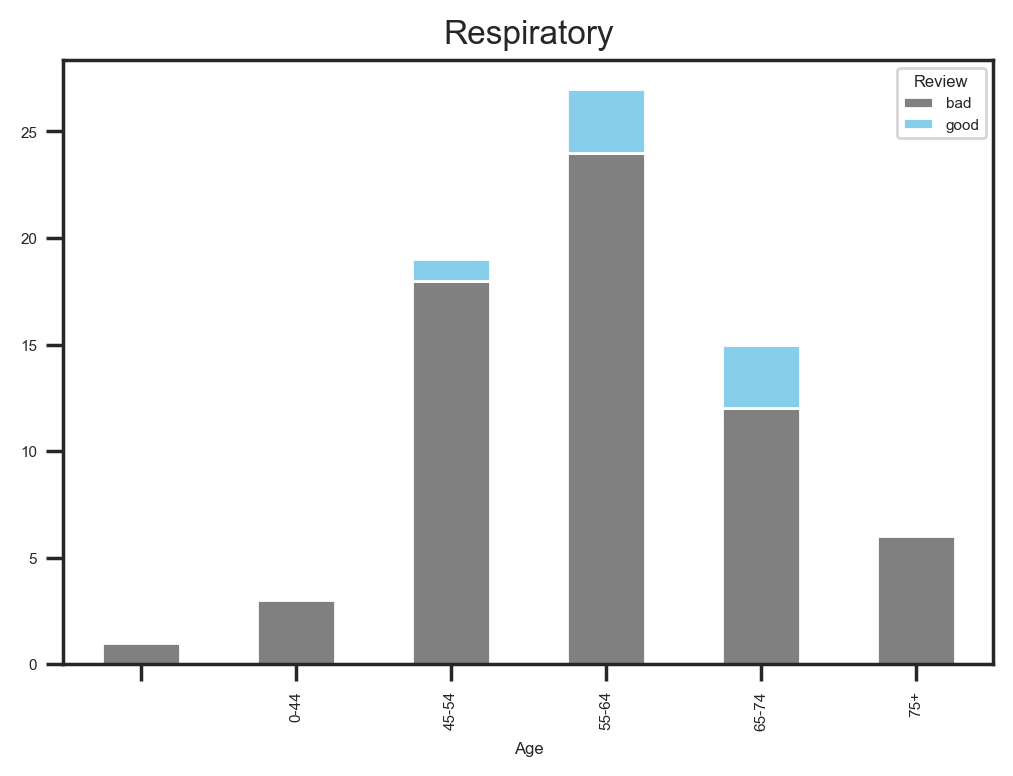

In [81]:
df_plot = df_resp.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Respiratory', fontsize=12)

Text(0.5, 1.0, 'Weight Loss / Gain')

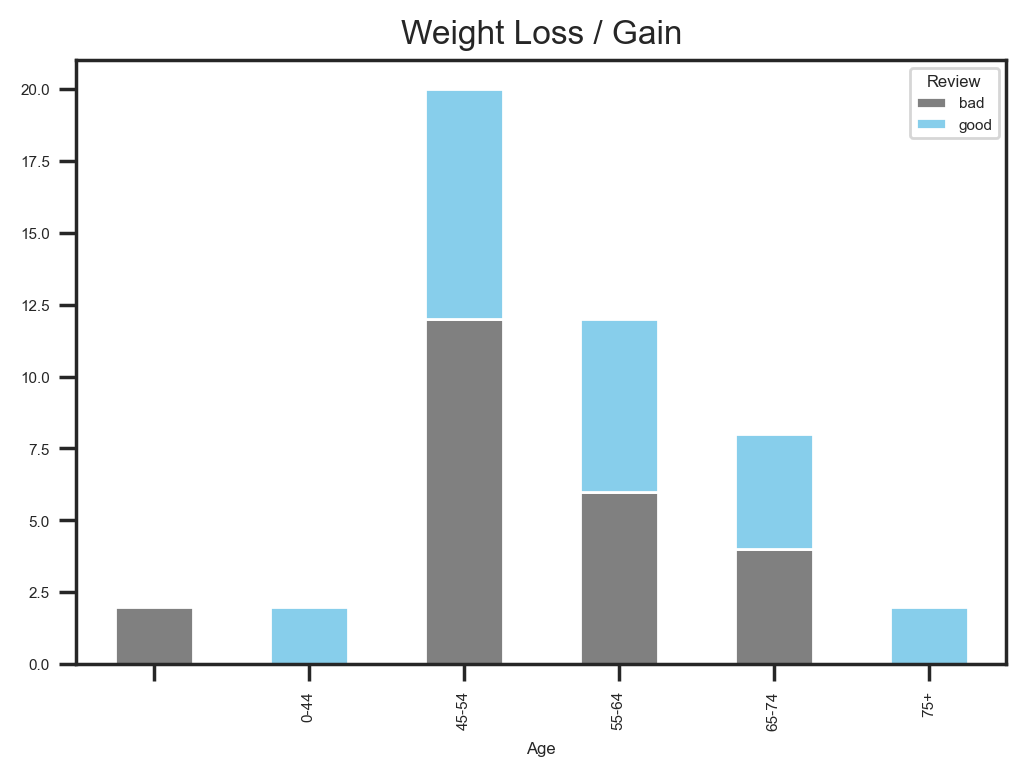

In [82]:
df_plot = df_weight.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Weight Loss / Gain', fontsize=12)

Text(0.5, 1.0, 'Headache')

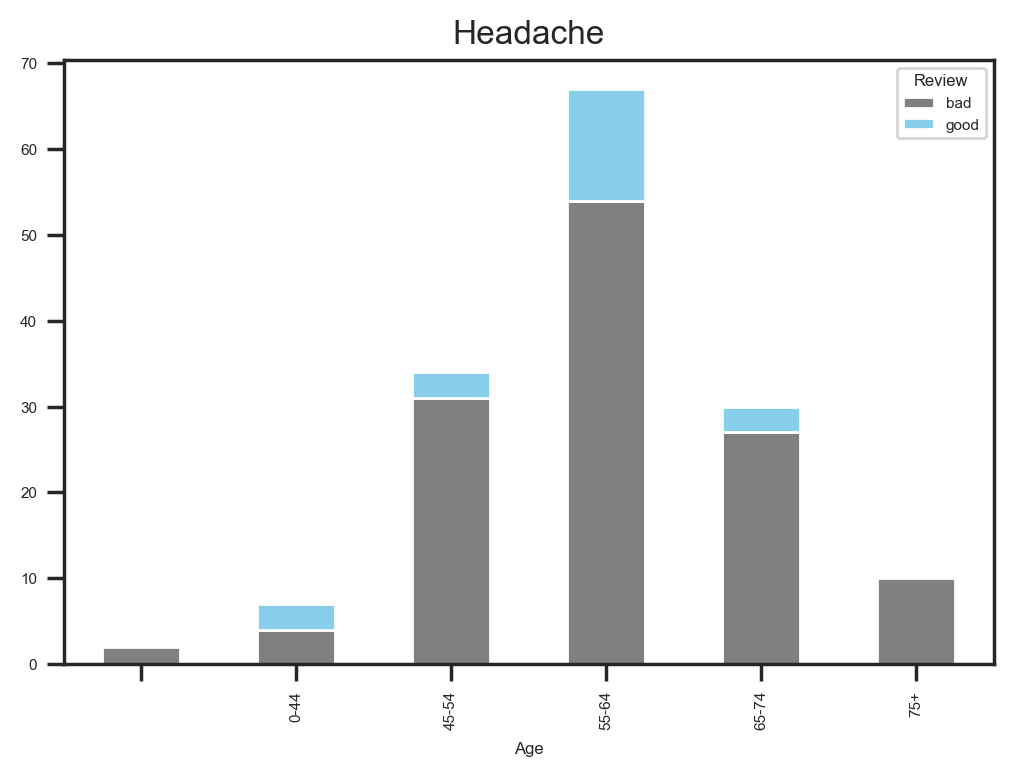

In [83]:
df_plot = df_headache.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
#df_plot
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Headache', fontsize=12)

Text(0.5, 1.0, 'Menstrual')

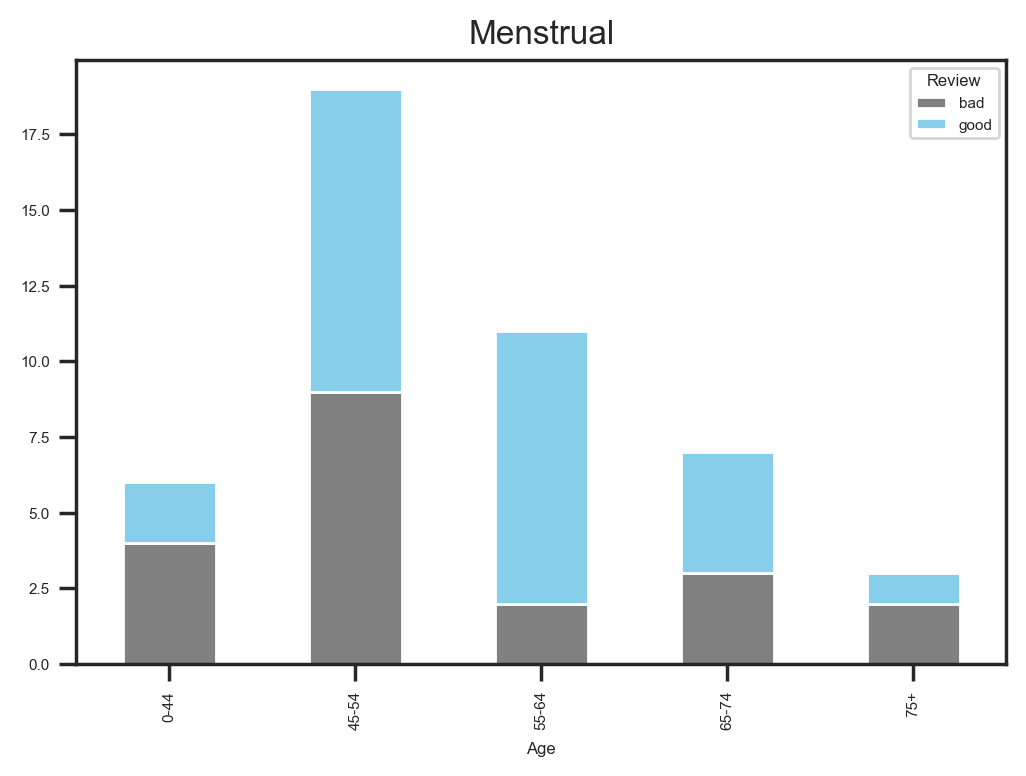

In [97]:
df_plot = df_menstrual.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
#df_plot
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Menstrual', fontsize=12)

Text(0.5, 1.0, 'Fatigue')

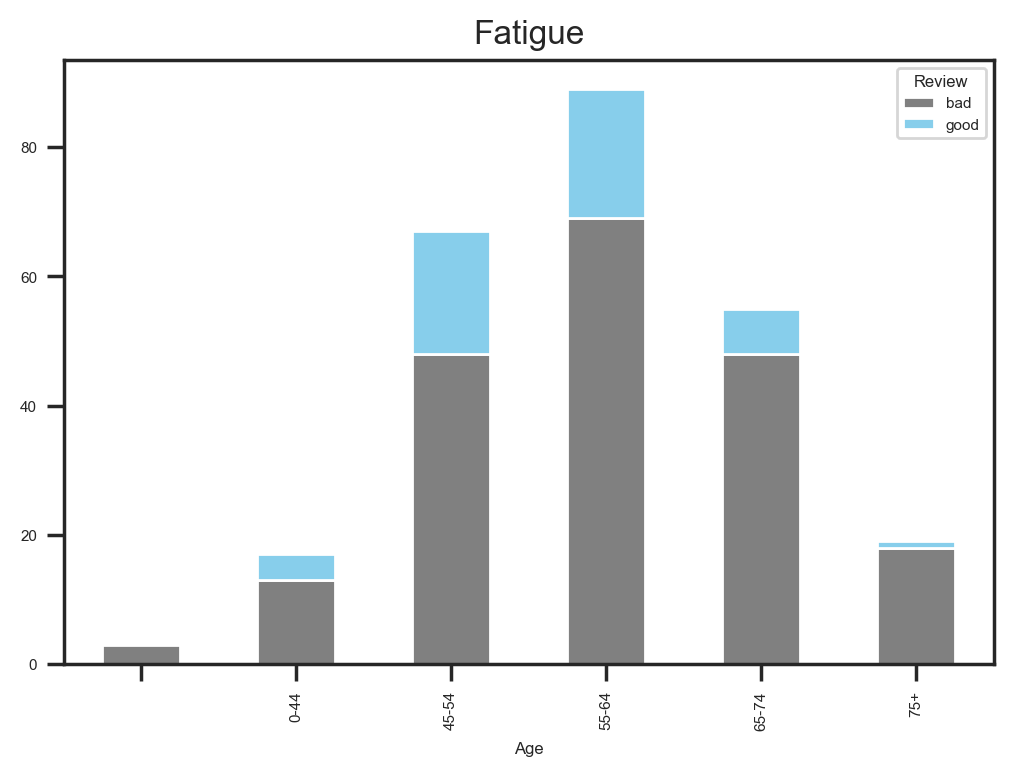

In [101]:
df_plot = df_fatigue.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
#df_plot
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Fatigue', fontsize=12)

Text(0.5, 1.0, 'Body Temp')

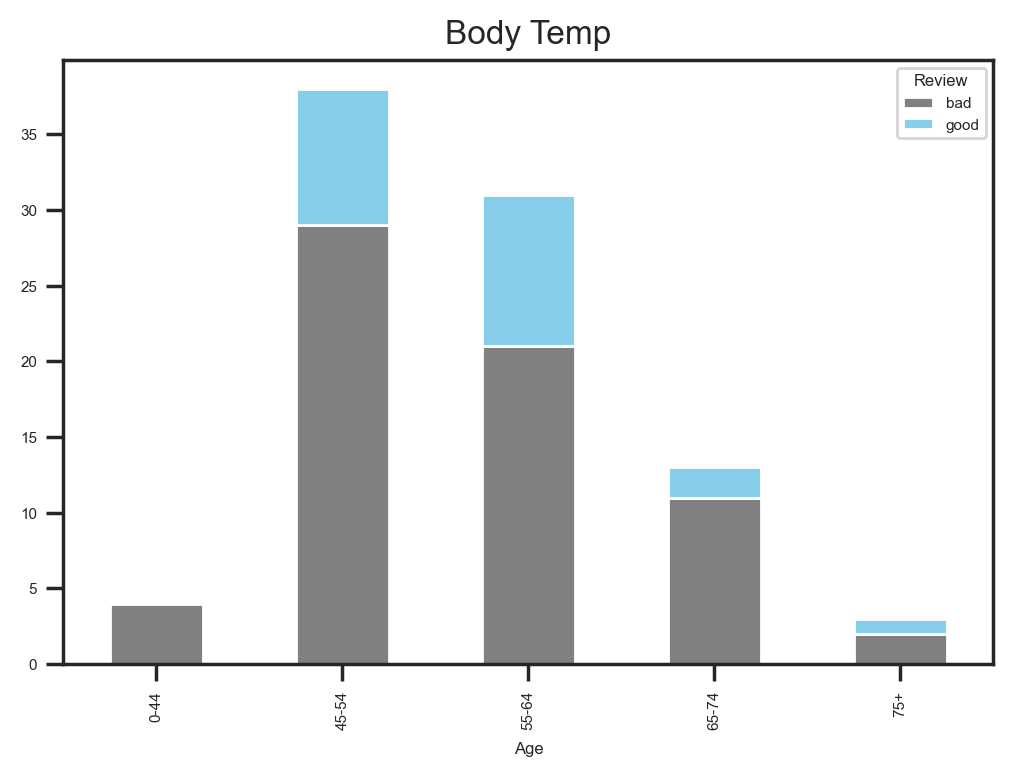

In [95]:
df_plot = df_bodytemp.groupby(['Age', 'Review']).size().reset_index().pivot(columns='Review', index='Age', values=0)
#df_plot
df_plot.plot(kind='bar', stacked=True, color=["gray", "skyblue"])
plt.title('Body Temp', fontsize=12)

# Side Effect Distribution on the top 3 Drugs

In [301]:
df_reclast = df_side_effects.loc[df_side_effects['Drug'].str.contains("reclast", case=False)]
df_prolia  = df_side_effects.loc[df_side_effects['Drug'].str.contains("prolia", case=False)]
df_actonel  = df_side_effects.loc[df_side_effects['Drug'].str.contains("actonel", case=False)]

## Reclast

In [302]:
df_temp = df_reclast.groupby(['Age'])['Drug'].count().reset_index()
df_temp

,Age,Drug
0,,4
1,0-44,17
2,45-54,86
3,55-64,195
4,65-74,117
5,75+,39


In [303]:
df_reclast2 = df_reclast.groupby(['Age', 'side_tf'])['Drug'].count().reset_index()

In [304]:
sum = []
for age in df_reclast2['Age']:
    if age == "":
        sum.append(4)
    elif age == '0-44':
        sum.append(17)
    elif age == '45-54':
        sum.append(86)
    elif age == '55-64':
        sum.append(195)
    elif age == '65-74':
        sum.append(117)
    elif age == '75+':
        sum.append(39)

In [305]:
df_reclast2['Sum'] = sum
df_reclast2['Percent'] = round(df_reclast2['Drug']/df_reclast2['Sum']*100,0)

Text(0.5, 1.0, 'Reclast')

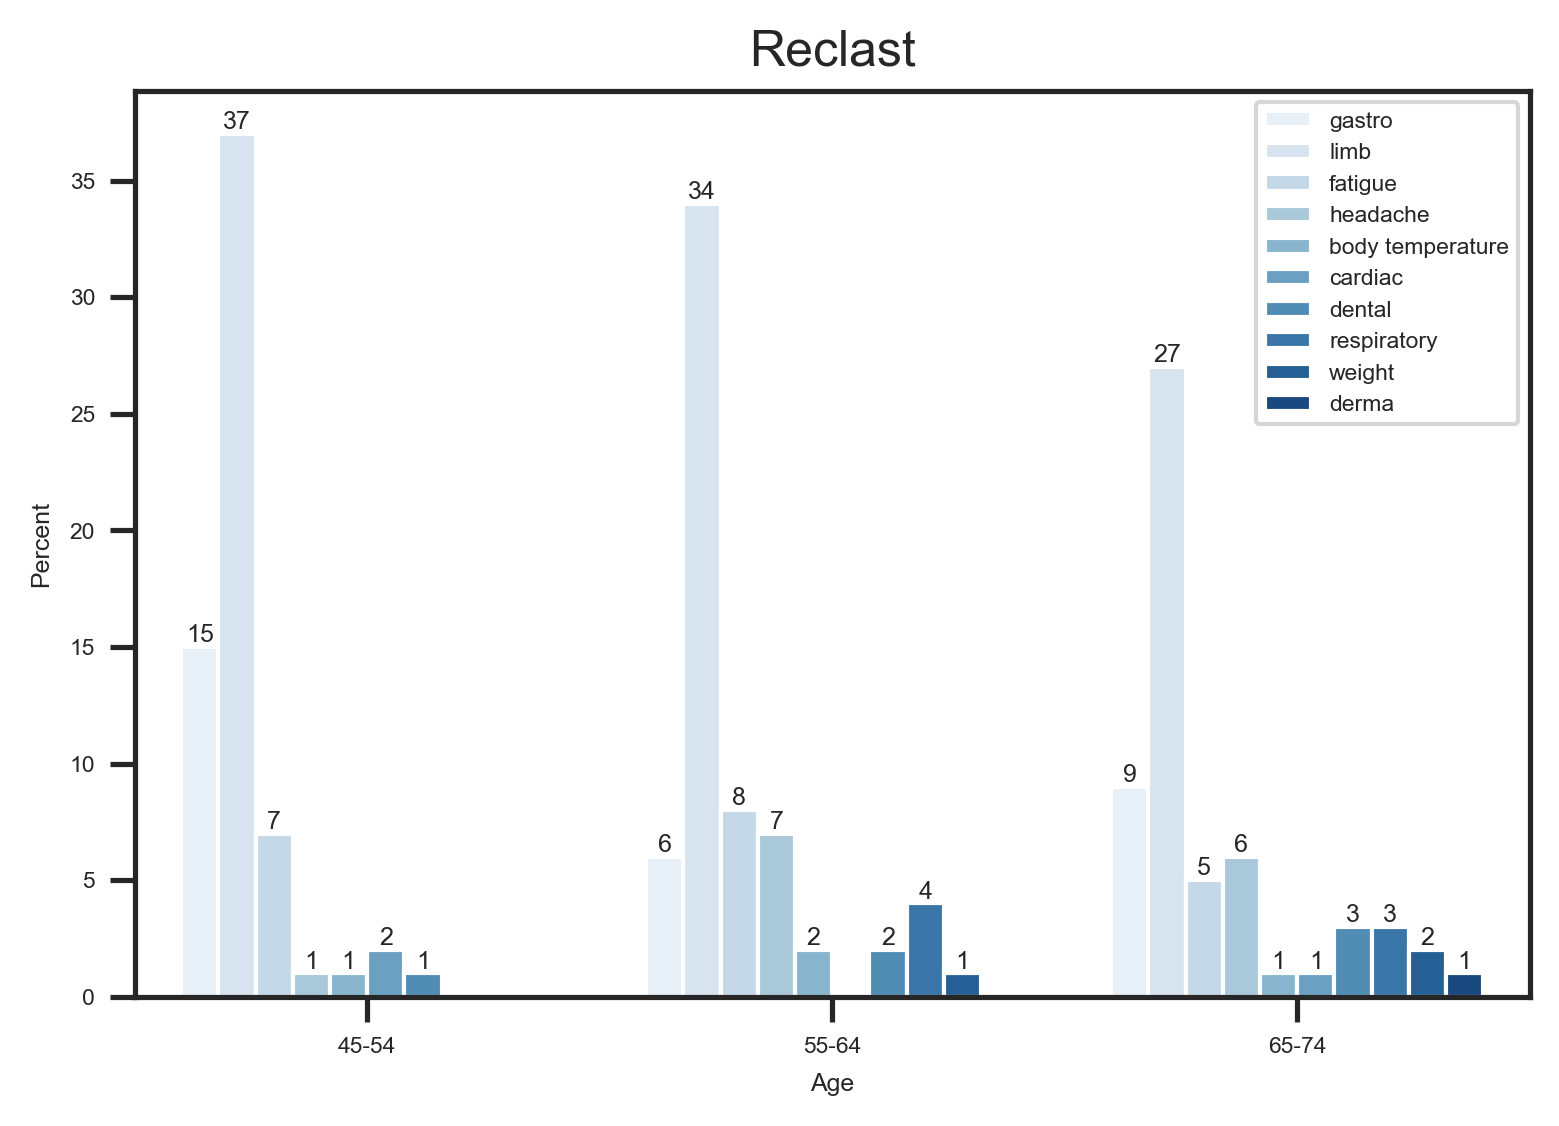

In [306]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300},
        font_scale=0.5,
        style="white"
        )
    
sns.set_style('ticks')
fig, ax = plt.subplots()
#fig.set_size_inches(12,6)
ax = sns.barplot(x='Age', y='Percent', hue = 'side_tf', data = df_reclast2[df_reclast2['side_tf'] != 'other'], palette = 'Blues', order = ["45-54", "55-64", "65-74"])
plt.legend(loc='upper right')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Reclast', fontsize=12)

## Prolia

In [307]:
df_temp = df_prolia.groupby(['Age'])['Drug'].count().reset_index()

In [308]:
df_prolia2 = df_prolia.groupby(['Age', 'side_tf'])['Drug'].count().reset_index()

In [309]:
sum = []
for age in df_prolia2['Age']:
    if age == "":
        sum.append(5)
    elif age == '0-44':
        sum.append(3)
    elif age == '45-54':
        sum.append(23)
    elif age == '55-64':
        sum.append(114)
    elif age == '65-74':
        sum.append(86)
    elif age == '75+':
        sum.append(31)

In [310]:
df_prolia2['Sum'] = sum
df_prolia2['Percent'] = round(df_prolia2['Drug']/df_prolia2['Sum']*100,0)

Text(0.5, 1.0, 'Prolia')

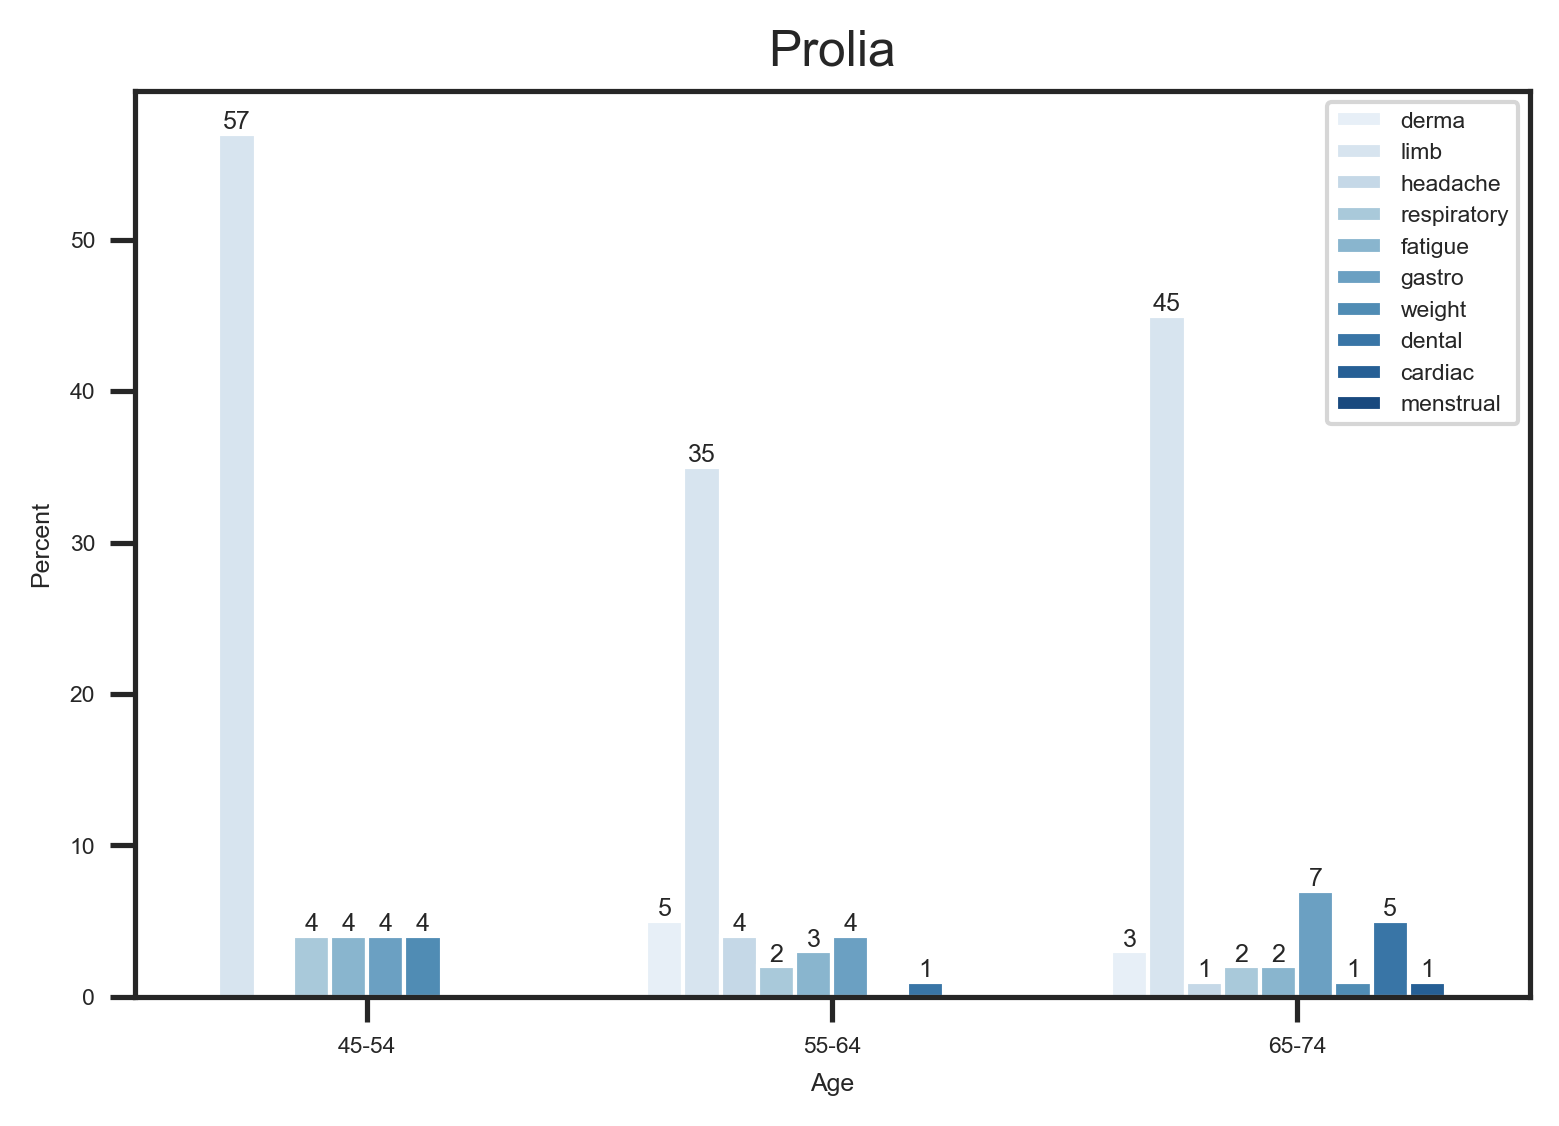

In [311]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300},
        font_scale=0.5,
        style="white"
        )
        
sns.set_style('ticks')
fig, ax = plt.subplots()
#fig.set_size_inches(12,6)
ax = sns.barplot(x='Age', y='Percent', hue = 'side_tf', data = df_prolia2[df_prolia2['side_tf'] != 'other'], palette = 'Blues', order = ["45-54", "55-64", "65-74"])
plt.legend(loc='upper right')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Prolia', fontsize=12)

## Actonel

In [312]:
df_temp = df_actonel.groupby(['Age'])['Drug'].count().reset_index()

In [313]:
df_actonel2 = df_actonel.groupby(['Age', 'side_tf'])['Drug'].count().reset_index()

In [314]:
sum = []
for age in df_actonel2['Age']:
    if age == "":
        sum.append(2)
    elif age == '0-44':
        sum.append(8)
    elif age == '45-54':
        sum.append(35)
    elif age == '55-64':
        sum.append(57)
    elif age == '65-74':
        sum.append(18)
    elif age == '75+':
        sum.append(16)

In [315]:
df_actonel2['Sum'] = sum
df_actonel2['Percent'] = round(df_actonel2['Drug']/df_actonel2['Sum']*100,0)

Text(0.5, 1.0, 'Actonel')

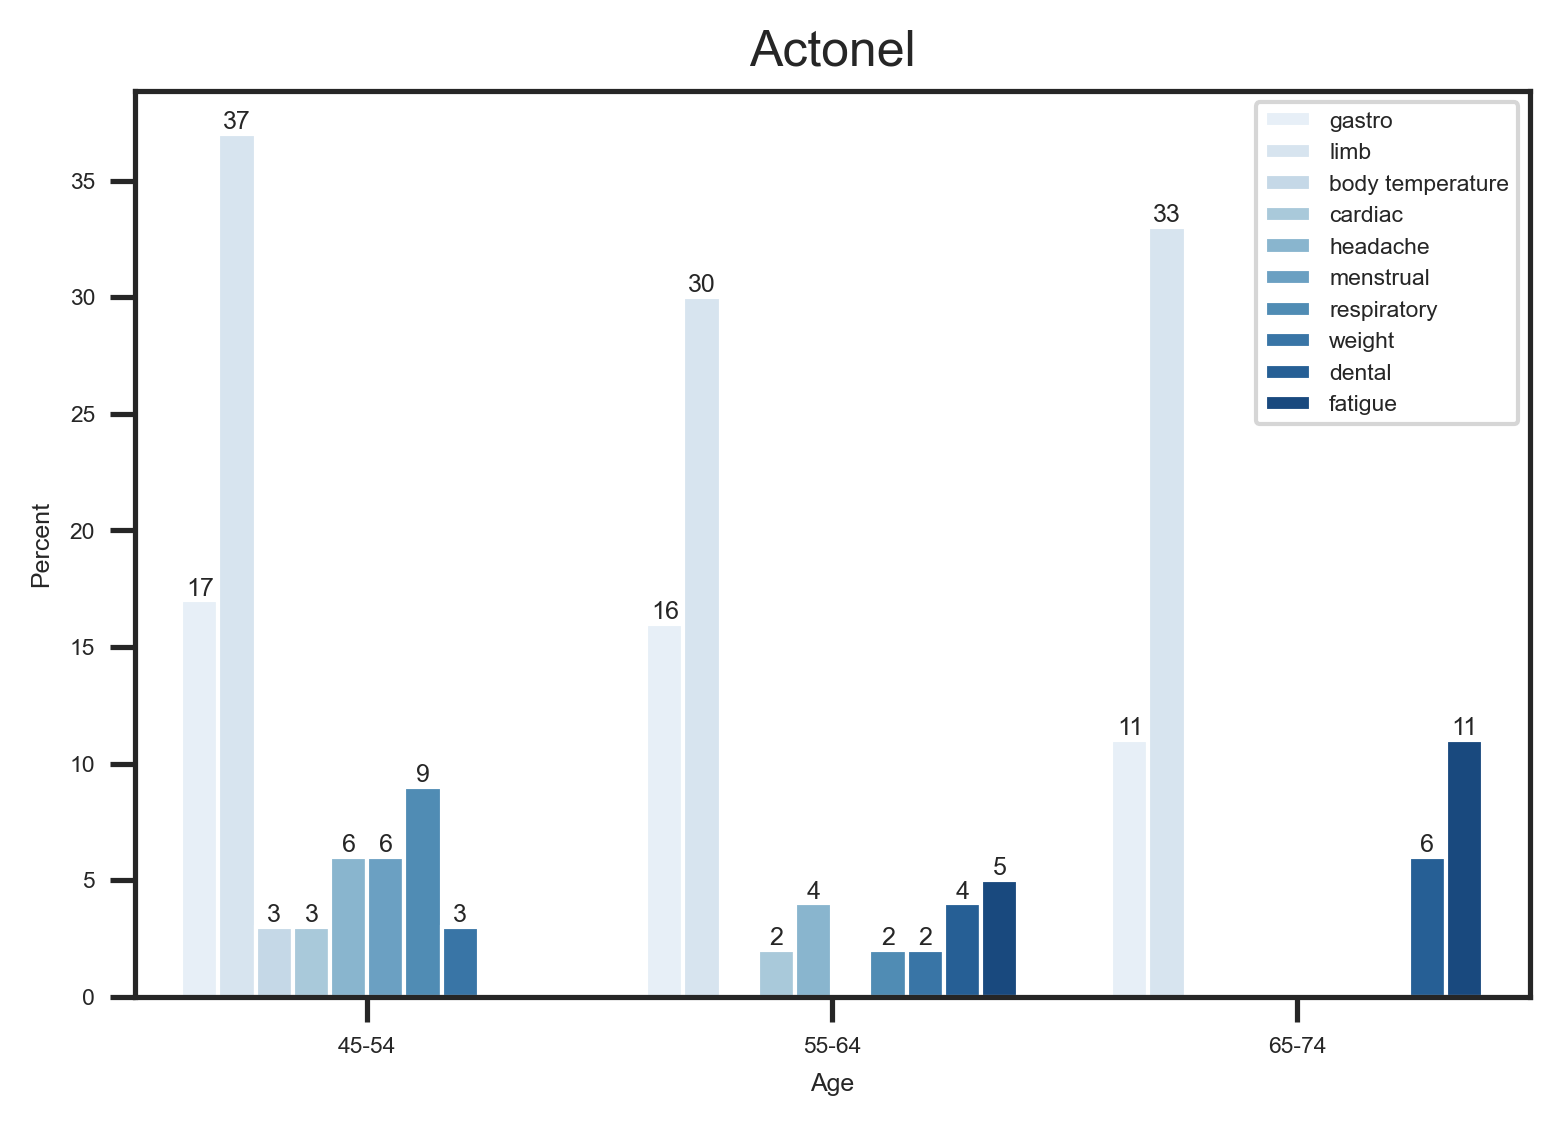

In [317]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300},
        font_scale=0.5,
        style="white"
        )
        
sns.set_style('ticks')
fig, ax = plt.subplots()
#fig.set_size_inches(12,6)
ax = sns.barplot(x='Age', y='Percent', hue = 'side_tf', data = df_actonel2[df_actonel2['side_tf'] != 'other'], palette = 'Blues', order = ["45-54", "55-64", "65-74"])
plt.legend(loc='upper right')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Actonel', fontsize=12)    